In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn.functional as F

In [2]:
data1 = np.load('/kaggle/input/da5401/embeddings_1.npy')
data2 = np.load('/kaggle/input/da5401/embeddings_2.npy')

X = np.concatenate((data1, data2), axis=0)


In [3]:
X.shape

(198982, 1024)

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer

with open('/kaggle/input/da5401/icd_codes_1.txt', 'r') as file1, open('/kaggle/input/da5401/icd_codes_2.txt', 'r') as file2:
    y1 = [line.strip().split(';') for line in file1]
    y2 = [line.strip().split(';') for line in file2]

y_combined = y1 + y2

mlb = MultiLabelBinarizer()
mlb.fit(y_combined)

y_encoded_1 = mlb.transform(y1)
y_encoded_2 = mlb.transform(y2)

y_encoded = np.concatenate((y_encoded_1, y_encoded_2), axis=0)



In [5]:
y_encoded.shape

(198982, 1400)

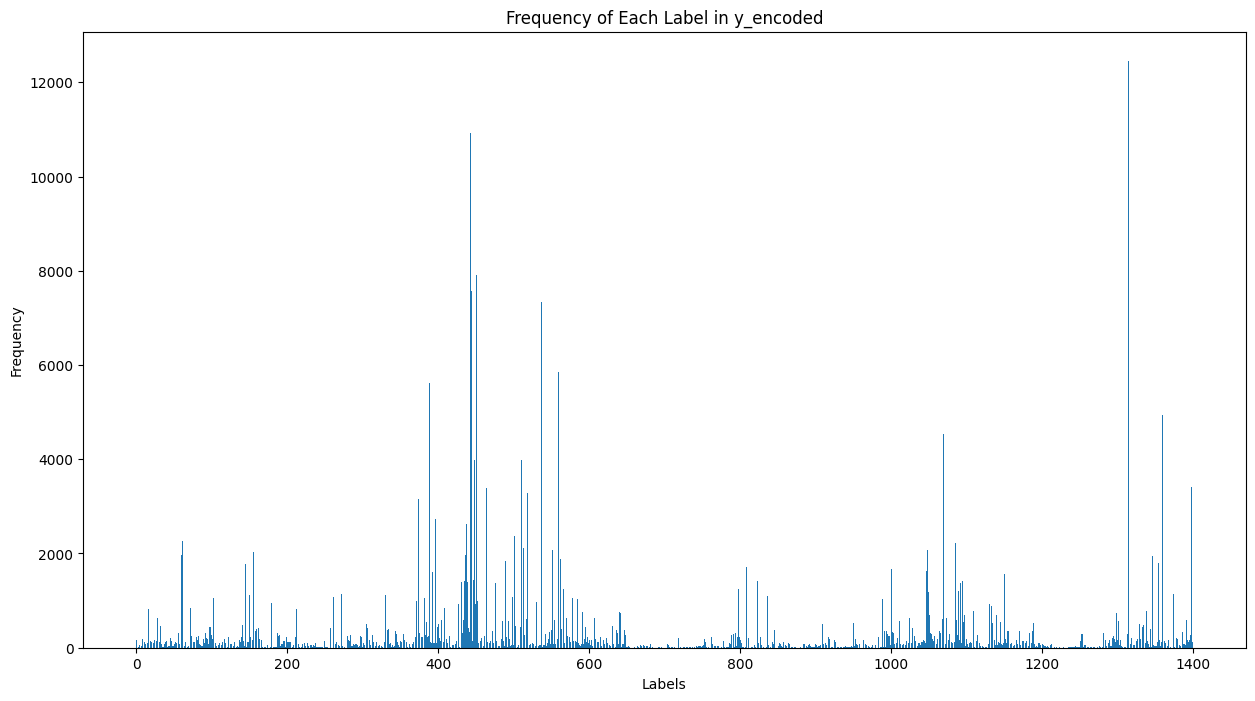

In [6]:
import matplotlib.pyplot as plt

label_frequencies = np.sum(y_encoded, axis=0)

plt.figure(figsize=(15, 8))
plt.bar(range(1400), label_frequencies)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Frequency of Each Label in y_encoded')
plt.show()

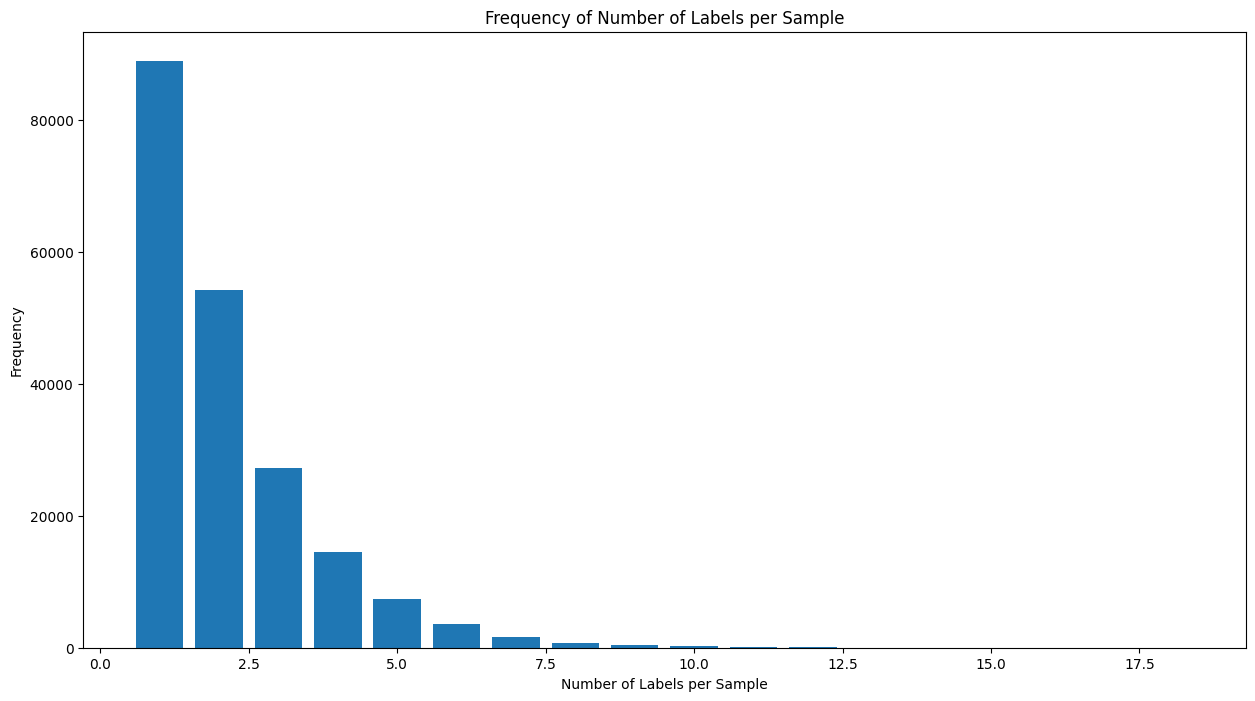

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Calculate the number of labels for each sample
labels_per_sample = np.sum(y_encoded, axis=1)

# Count occurrences of each label count
label_count_freq = Counter(labels_per_sample)

# Extract the unique label counts and their frequencies
label_counts = list(label_count_freq.keys())
frequencies = list(label_count_freq.values())

# Plotting
plt.figure(figsize=(15, 8))
plt.bar(label_counts, frequencies)
plt.xlabel('Number of Labels per Sample')
plt.ylabel('Frequency')
plt.title('Frequency of Number of Labels per Sample')
plt.show()


In [8]:
X.shape

(198982, 1024)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(X)

In [10]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.float32)

In [11]:
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [12]:
import torch
import torch.nn as nn

class MultiLabelNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiLabelNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1024)  
        self.bn2 = nn.BatchNorm1d(1024)   
        self.fc3 = nn.Linear(1024, output_dim) 
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = torch.sigmoid(x)  # Sigmoid activation for multi-label output
        return x


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
input_dim = X.shape[1]
output_dim = y_encoded.shape[1]
model = MultiLabelNN(input_dim, output_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [15]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.0042
Epoch [2/10], Loss: 0.0004
Epoch [3/10], Loss: 0.0010
Epoch [4/10], Loss: 0.0028
Epoch [5/10], Loss: 0.0011
Epoch [6/10], Loss: 0.0017
Epoch [7/10], Loss: 0.0028
Epoch [8/10], Loss: 0.0019
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0013


In [18]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_tensor.to(device))
    y_pred = (y_pred_prob > 0.5).float()

In [23]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f2_score, _ = precision_recall_fscore_support(y_encoded, y_pred.cpu().numpy(), average='micro', beta=2)

print(f'Micro F2 Score: {f2_score}')


Micro F2 Score: 0.9260086436785117


In [77]:
test = np.load('/kaggle/input/da5401/test_data.npy')

In [78]:
test.shape

(99490, 1024)

In [79]:
test = scaler.transform(test)

In [80]:
test = torch.tensor(test, dtype=torch.float32).to(device)

In [81]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(test)
    y_pred = (y_pred_prob > 0.5).float()

In [82]:
predictions = mlb.inverse_transform(y_pred.cpu().numpy())

In [83]:
len(predictions)

99490

In [84]:


# Initialize a list to hold formatted rows
formatted_data = []

# Process each prediction
for idx, codes in enumerate(predictions, start=1):
    # Sort the codes lexicographically and join with ';'
    sorted_codes = ";".join(sorted(codes))
    # Add a dictionary entry with 'id' and 'labels'
    formatted_data.append({"id": idx, "labels": sorted_codes})

# Convert the list to a DataFrame
submission_df = pd.DataFrame(formatted_data)

# Write to CSV file
submission_df.to_csv('submission.csv', index=False)
